In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load the datasets
train_df = pd.read_csv('/content/drive/My Drive/Drug review/drugsComTrain_raw.csv')
test_df = pd.read_csv('/content/drive/My Drive/Drug review/drugsComTest_raw.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

train_df = train_df.sample(n=500, random_state=42)
test_df = test_df.sample(n=500, random_state=42)

In [ ]:
# Tokenize and preprocess review text with reduced max_length
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_reviews(reviews, max_length=128):
    return tokenizer(reviews.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_tokens = tokenize_reviews(train_df['review'])
test_tokens = tokenize_reviews(test_df['review'])

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: val.clone().detach() for key, val in encodings.items()}
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Example for Sentiment Analysis
train_labels = train_df['rating'].apply(lambda x: 0 if x <= 4 else (2 if x >= 8 else 1)).tolist()
test_labels = test_df['rating'].apply(lambda x: 0 if x <= 4 else (2 if x >= 8 else 1)).tolist()

train_dataset = ReviewDataset(train_tokens, train_labels)
test_dataset = ReviewDataset(test_tokens, test_labels)

# Load pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Set up training arguments and trainer with smaller batch size
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,
    fp16=True,  # Enable mixed precision training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.095000
20,1.080800
30,1.061200


{'eval_loss': 1.040648102760315,
 'eval_runtime': 115.8852,
 'eval_samples_per_second': 4.315,
 'eval_steps_per_second': 0.276,
 'epoch': 0.9841269841269841}

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from bertopic import BERTopic
from tqdm import tqdm

# Tokenize and preprocess review text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_reviews(reviews, max_length=128):
    return tokenizer(reviews.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_tokens = tokenize_reviews(train_df['review'])
test_tokens = tokenize_reviews(test_df['review'])

# Load pre-trained DistilBERT model
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to get embeddings in batches
def get_embeddings(tokens, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, tokens['input_ids'].shape[0], batch_size)):

            batch = {key: val[i:i + batch_size] for key, val in tokens.items()}
            outputs = model(**batch)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings)
    return torch.cat(embeddings)

# Get embeddings for train and test sets
train_embeddings = get_embeddings(train_tokens)
test_embeddings = get_embeddings(test_tokens)

# Apply BERTopic
topic_model = BERTopic()
train_topics, train_probs = topic_model.fit_transform(train_df['review'], train_embeddings.numpy())

# Visualize topics
topic_model.visualize_topics()

100%|██████████| 16/16 [02:03<00:00,  7.71s/it]


In [ ]:
from transformers import BertForSequenceClassification
# Fine-tune BERT for multi-class classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['condition'].unique()))

train_labels = train_df['condition'].astype('category').cat.codes.tolist()
test_labels = test_df['condition'].astype('category').cat.codes.tolist()

train_dataset = ReviewDataset(train_tokens, train_labels)
test_dataset = ReviewDataset(test_tokens, test_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,5.023100
20,4.991700
30,4.966800


TrainOutput(global_step=31, training_loss=4.990076864919355, metrics={'train_runtime': 764.5856, 'train_samples_per_second': 0.654, 'train_steps_per_second': 0.041, 'total_flos': 32664438104064.0, 'train_loss': 4.990076864919355, 'epoch': 0.9841269841269841})

In [ ]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT model for regression
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Convert labels to floats for regression task
train_labels = train_df['rating'].astype(float).tolist()  # Convert to float
test_labels = test_df['rating'].astype(float).tolist()  # Convert to float

train_dataset = ReviewDataset(train_tokens, train_labels)
test_dataset = ReviewDataset(test_tokens, test_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,55.421000
20,56.114100
30,49.951300


{'eval_loss': 49.160892486572266,
 'eval_runtime': 229.1748,
 'eval_samples_per_second': 2.182,
 'eval_steps_per_second': 0.14,
 'epoch': 0.9841269841269841}

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

# Define threshold for binary classification
threshold = 5  # You can adjust this threshold based on your data

# Apply threshold to create binary labels
train_labels = train_df['usefulCount'].apply(lambda x: 1 if x > threshold else 0).tolist()
test_labels = test_df['usefulCount'].apply(lambda x: 1 if x > threshold else 0).tolist()

train_dataset = ReviewDataset(train_tokens, train_labels)
test_dataset = ReviewDataset(test_tokens, test_labels)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up training arguments and trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.564300
20,0.612900
30,0.632000
40,0.476000
50,0.510100
60,0.467400


{'eval_loss': 0.5650766491889954,
 'eval_runtime': 231.9376,
 'eval_samples_per_second': 2.156,
 'eval_steps_per_second': 0.138,
 'epoch': 1.0}

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

# Apply rating transformation to create multi-class labels
train_labels = train_df['rating'].apply(lambda x: 0 if x <= 4 else (2 if x >= 8 else 1)).tolist()
test_labels = test_df['rating'].apply(lambda x: 0 if x <= 4 else (2 if x >= 8 else 1)).tolist()

train_dataset = ReviewDataset(train_tokens, train_labels)
test_dataset = ReviewDataset(test_tokens, test_labels)

# Initialize the model for multi-class classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Set up training arguments and trainer
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train and evaluate the model
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.110900
20,1.108400
30,1.061800
40,1.003900
50,1.014600
60,0.971600


{'eval_loss': 0.9382333755493164,
 'eval_runtime': 228.1173,
 'eval_samples_per_second': 2.192,
 'eval_steps_per_second': 0.14,
 'epoch': 1.0}

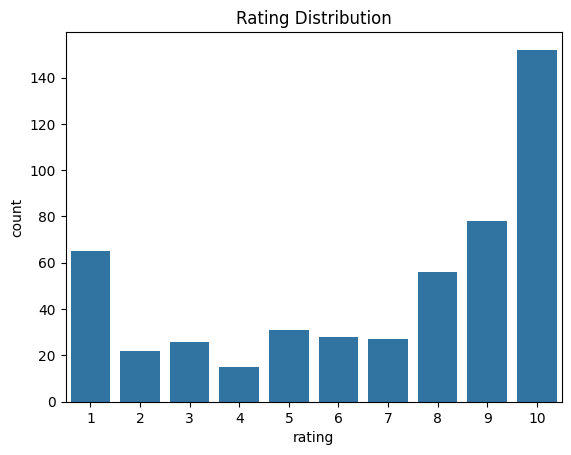

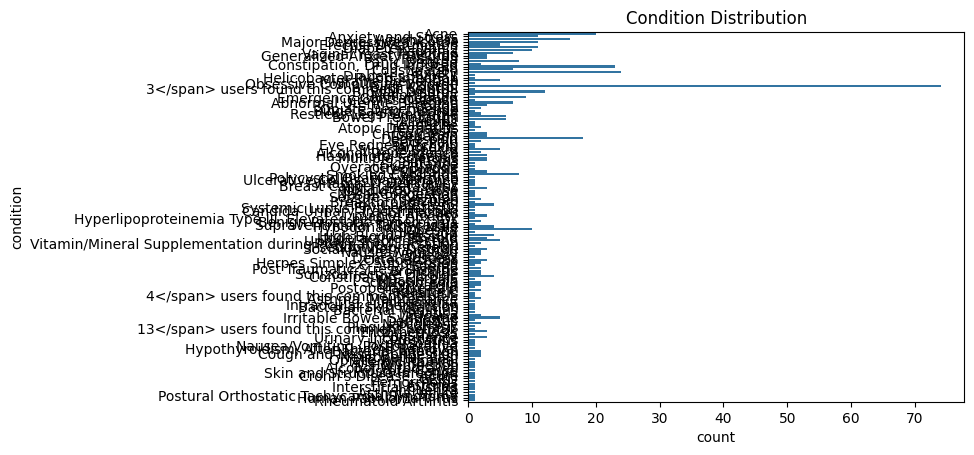

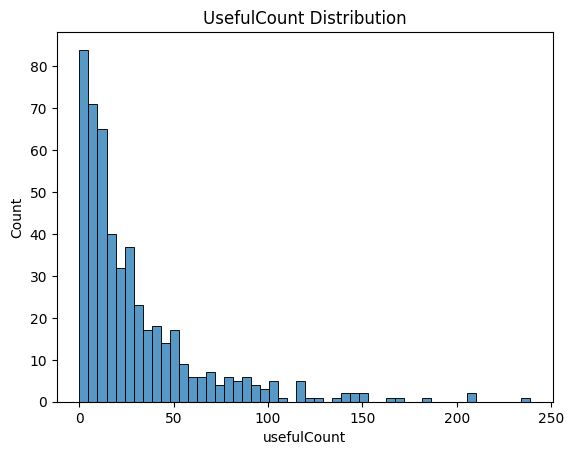

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
sns.countplot(x='rating', data=train_df)
plt.title('Rating Distribution')
plt.show()

# Condition distribution
sns.countplot(y='condition', data=train_df)
plt.title('Condition Distribution')
plt.show()

# UsefulCount distribution
sns.histplot(train_df['usefulCount'], bins=50)
plt.title('UsefulCount Distribution')
plt.show()